# COVID-19와 IT 산업 환경 변화

### 신용카드 매출액 데이터를 활용한 소비시장 분석

* COVID-29 강혜선 김덕우 서우린

# 1. 왜 코로나 위기 속 IT 산업 성장에 주목하는가?
코로나와 사회의 대변혁과 패러다임 전환
* 패러다임 전환의 역사
  * 1970s 반도체
  * 1980s pc


In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [2]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from matplotlib import rc
import pandas as pd
import os
from glob import glob
import numpy as np
import warnings
warnings.filterwarnings('ignore')
font_path = '/content/drive/MyDrive/datacon_data/fonts/NanumFontSetup_TTF_GOTHIC/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
# label_name = fm.FontProperties(fname=font_path)
plt.rc('font', family=font_name) 

In [3]:
import random
# 컬럼 개수만큼 중복되지 않는 rgb코드 랜덤 생성
def color_gen(num):
  ret = []
  while 1:
    code = ''
    for i in range(6):
      gen = random.randrange(0,16)
      if gen>=10:
        gen = gen+55
        code+=chr(gen)
      else: code+=str(gen)
    if code not in ret:
      ret.append('#'+code)
    if len(ret)==num:
      break
  return ret

In [4]:
# 코로나 확진자 월별 변환 함수
def convert_monthly(data,start = '202001',end = '202203'):
  data['date'] = data['일자'].str.slice(0,7)
  data['date'] = data['date'].str.replace('-', '')
  data.drop(['일자'],axis=1,inplace=True)
  data.replace('-','0',inplace=True)
  data.replace(np.NaN,'0',inplace=True)
  cl = list(data.columns)
  c = [cl[i] for i in range(len(cl)) if not 'Unnamed' in cl[i]]
  data = data[c]
  data = data.drop([data.index[0]])
  for i in c[:-1]:
    data[i] = data[i].str.replace(',', '').astype('int64')
  data = data.groupby('date',axis=0)[c[:-1]].sum()
  data = data.loc[start:end]
  return data

In [5]:
# 파편화된 파일 하나로 합치기
def load_data(df,cols,paths):
  ret = pd.read_csv(paths,sep='\n',names=['text'])
  temp = ret.text.str.split("^")
  t = pd.DataFrame(temp)
  t = pd.DataFrame(list(t['text']),columns=cols)
  df = df.append(t,ignore_index=True)
  return df

In [6]:
# 데이터 표로 그리기
def showplot(in1,in2=[],title='매출 증가 업종',subtitle='()'):
  plt.figure(figsize = (10,4))
  a = 0
  if len(in2)>=1: a+=1
  size = len(in1)+a
  cnt = 1
  for ty in in1:
    sub = card.loc[card['업종']==ty]
    sub['매출'] = sub['매출'].astype('int32')
    sub = sub.groupby('date',axis = 0)['매출'].sum()
    plt.style.use('ggplot')
    plt.subplot(1,size,cnt)
    plt.plot(sub)
    ax = plt.gca()
    plt.title(ty,fontproperties=font_name)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    cnt+=1

  if len(in2)>=1:
    b = card.loc[card['세부업종']==in2[0]]
    b['매출'] = b['매출'].astype('int32')
    b = b.groupby('date',axis = 0)['매출'].sum()
    for i in range(1,len(in2)):
      sub = card.loc[card['세부업종']==ty]
      sub['매출'] = sub['매출'].astype('int32')
      sub = sub.groupby('date',axis = 0)['매출'].sum()
      for idx in sub.index.values.tolist():
        b[idx]+=sub[idx]
    plt.style.use('ggplot')
    plt.subplot(1,size,cnt)
    plt.plot(b)
    ax = plt.gca()
    plt.title(in2[0],fontproperties=font_name)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.suptitle(title+subtitle,fontsize=20,fontproperties=font_name)
  plt.show()

In [30]:
# 데이터 표로 그리기2
def showplot2(in1,in2=[],title='매출 증가 업종',subtitle='()'):
  plt.figure(figsize = (15,4))
  size = len(in1)+len(in2)
  cnt = 1
  for ty in in1:
    sub = card.loc[card['업종']==ty]
    sub['매출'] = sub['매출'].astype('int32')
    sub = sub.groupby('date',axis = 0)['매출'].sum()
    plt.style.use('ggplot')
    plt.subplot(1,size,cnt)
    plt.plot(sub)
    ax = plt.gca()
    plt.title(ty,fontproperties=font_name)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    cnt+=1
  for ty in in2:
    sub = card.loc[card['세부업종']==ty]
    sub['매출'] = sub['매출'].astype('int32')
    sub = sub.groupby('date',axis = 0)['매출'].sum()
    plt.style.use('ggplot')
    plt.subplot(1,size,cnt)
    plt.plot(sub)
    ax = plt.gca()
    plt.title(ty,fontproperties=font_name)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    cnt+=1
  
  
  plt.suptitle(title+subtitle,fontsize=20,fontproperties=font_name)
  plt.show()

# 2. 코로나 위기 따른 시장 수요 및 산업 구조 변화
####코로나 사태 현황
* 코로나 확진자 추이 (20년 1월 ~ 22년 1월)
  * 국내 코로나 첫 확진자가 발생했던 2020년 1월 20일로부터 만 2년이 경과했다.
  * 만 2년 동안 총 누적 확진자는 약 70만명 (22.01.17 기준)

In [7]:
#코로나 확진자 정보
path = '/content/drive/MyDrive/datacon_data/data/covid/'
pathlist = glob(path+'*.csv')
print(pathlist)

['/content/drive/MyDrive/datacon_data/data/covid/covid_220306.csv', '/content/drive/MyDrive/datacon_data/data/covid/covid(old)_220306.csv', '/content/drive/MyDrive/datacon_data/data/covid/covid(gender)_220306.csv', '/content/drive/MyDrive/datacon_data/data/covid/covid(city)_220306.csv']


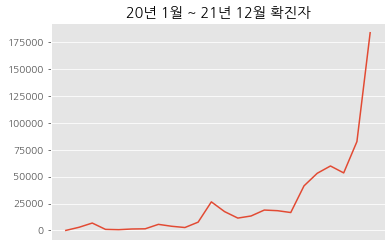

In [8]:
df = pd.read_csv(pathlist[0],encoding='euc-kr')
df = convert_monthly(df,end = '202112')
plt.style.use('ggplot')
plt.grid(True)
plt.plot(df['계(명)'])
plt.title('20년 1월 ~ 21년 12월 확진자')
ax = plt.gca()
ax.get_xaxis().set_visible(False)
plt.show()

#### 시장 수요 분석
* 데이터 분석
  * 카드 사용 금액 정보 약 750만여 건
  * 연령별 지역별로 세분화 되어 있는 데이터이기 때문에 업종별로 모두 통합
  * 약 260여개의 세부 업종 분류

In [9]:
cardpath = '/content/drive/MyDrive/datacon_data/data/card/'
cardpaths = glob(cardpath+'*.csv')
cols = ['date','업종','세부업종','연령대','성별','시','구','매출','거래량']
card = pd.DataFrame(columns=cols)
for i in cardpaths:
  card = load_data(card,cols,i)

In [10]:
# 필요없는 컬럼 삭제
card.drop(['연령대','성별','시','구'],axis=1,inplace=True)

In [11]:
card.tail(10)

,date,업종,세부업종,매출,거래량
7529497,202201,기타,비 영 리,188,253
7529498,202201,기타,기타전문점,356,720
7529499,202201,기타,기타전문점,49,126
7529500,202201,기타,기타전문점,58,100
7529501,202201,기타,기타전문점,208,175
7529502,202201,기타,기계 공구,90,91
7529503,202201,기타,기계 공구,169,64
7529504,202201,기타,비 영 리,39,86
7529505,202201,기타,비 영 리,29,23
7529506,202201,기타,기타전문점,125,143


In [12]:
type_ = set(card['업종'])
type_ = list(type_)
kind = set(card['세부업종'])
kind = list(kind)
print('업종의 개수 : {} , 세부업종의 개수 : {}'.format(len(type_),len(kind)))

업종의 개수 : 36 , 세부업종의 개수 : 258


* 대표 업종 비교를 위해 36개의 업종으로 비교

* 데이터 전처리
  * 월 단위 분석이 어려운 데이터 제거
  * 매 포함되지 않는 소비 항목 제거
  * 세부 분류를 유추할 수 없는 항목 제거
  * 소비와 연관성이 적은 항목 제거
  * 계절성이 짙어서 분석이 어려운 항목 제거

In [13]:
# 제거할 업종(추후 수정 필요)
del_type = ['레져업소','문화/취미','유통업비영리','레져용품','농업','기타']

type_ = [t for t in type_ if t not in del_type]
print('업종의 개수 : {}'.format(len(type_)))

업종의 개수 : 30


* 업종별 월단위 소비금액

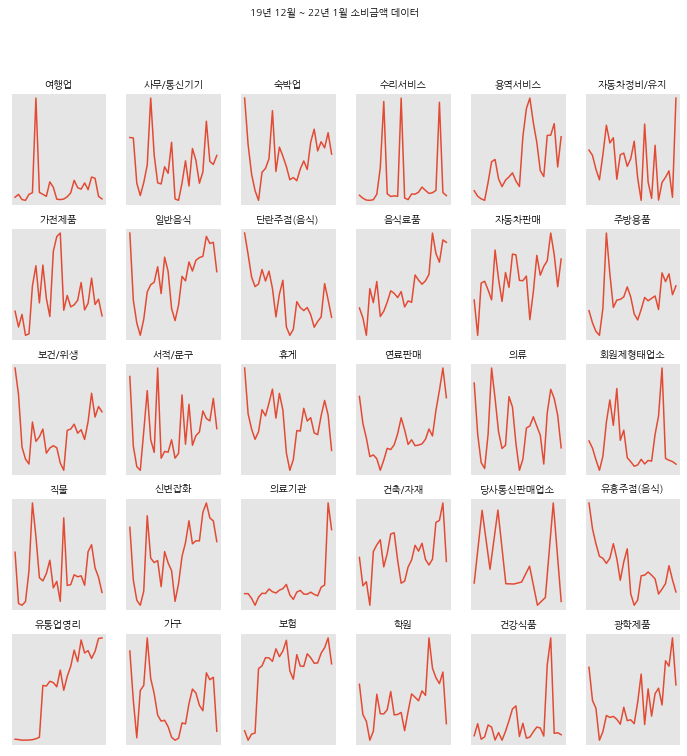

In [14]:
plt.figure(figsize = (12,12))
for i,ty in enumerate(type_):
  sub = card.loc[card['업종']==ty]
  sub['매출'] = sub['매출'].astype('int32')
  sub = sub.groupby('date',axis = 0)['매출'].sum()
  plt.style.use('ggplot')
  plt.subplot(5,6,i+1)
  plt.plot(sub)
  ax = plt.gca()
  plt.title(ty,fontproperties=font_name)
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  # plt.xlabel('date',fontproperties=font_name)
  # plt.ylabel('매출',fontproperties=font_name)
plt.suptitle('19년 12월 ~ 22년 1월 소비금액 데이터',fontsize=20,fontproperties=font_name)
plt.show()

* 평가 기준 - 타격지수(Risk Index)
  * 해당 업종의 소비가 코로나 확산기 중 (20년 1~3월) 얼마나 많이 증가/감소 했는지 나타내는 지수
  > $$RiskIndex = \sqrt{(R1+1)*(R2+1))}-1$$
  * 소비 변화율을 기하 평균으로 표현

In [15]:
card_tmp = card.copy()
card_tmp['매출'] = card_tmp['매출'].astype('float')
card_tmp.loc[card_tmp['매출']<=0]['매출'] = 1e-6
cat = []
risk2 = []
risk3 = []
for i in kind:
  sub = card_tmp.loc[card_tmp['세부업종']==i]
  sub = sub.groupby('date',axis=0)['매출'].sum()
  l = sub.index.values.tolist()
  if not ('202001' in l and '202002' in l and '202003' in l):
    continue
  cat.append(i)
  r2 = sub.loc['202002']/sub.loc['202001']
  r3 = sub.loc['202003']/sub.loc['202002']
  risk2.append(r2)
  risk3.append(r3)

risk_data = pd.DataFrame({'cat':cat,'risk_2':risk2,'risk_3':risk3})
risk_data['risk_index'] = [np.sqrt(x*y)-1 for x,y in zip(risk_data.risk_2,risk_data.risk_3)]
risk_data.head()

,cat,risk_2,risk_3,risk_index
0,여 객 선,0.401895,1.742426,-0.163178
1,출판인쇄물,0.752547,0.920937,-0.167505
2,양 품 점,0.584889,0.484465,-0.467686
3,일반 서적,0.807935,0.987524,-0.106773
4,미곡상,1.001430,6.092369,1.470037


Text(0.5, 1.0, 'Risk Index')

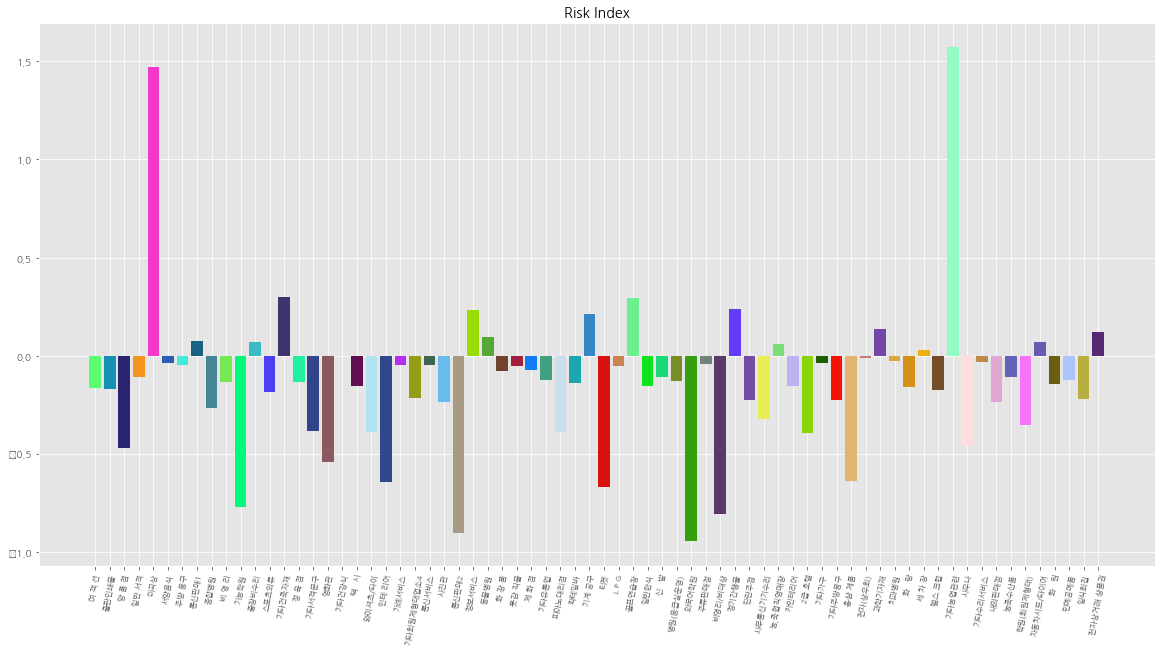

In [16]:
size = 70
colors = color_gen(size)
plt.figure(figsize=(20,10))
plt.style.use('ggplot')
plt.bar(x=risk_data.cat[:size],height=risk_data.risk_index[:size],color=colors)
plt.winter()
plt.xticks(rotation = 80,fontsize=8)

plt.title('Risk Index')

#### 소비 증가 항목
1. 홈
  1. 가구
  2. 주방
  3. 통신기기

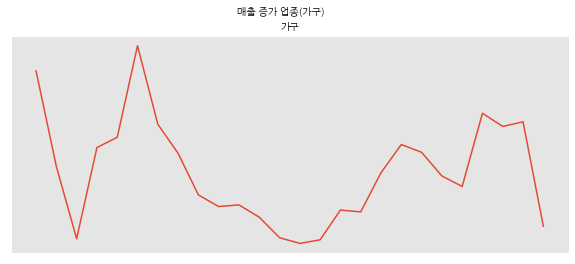

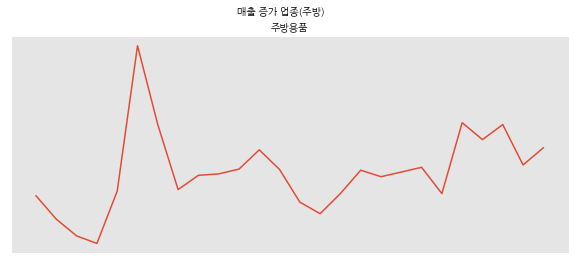

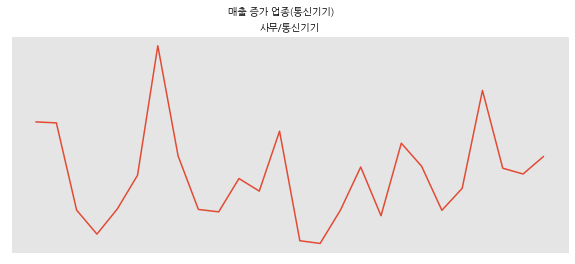

In [17]:
in1 = ['가구']
showplot(in1,subtitle='(가구)')
in1 = ['주방용품']
showplot(in1,subtitle='(주방)')
in1 = ['사무/통신기기']
in2 = ['컴퓨터','통신기기']
showplot(in1,subtitle='(통신기기)')

2. 비대면 소비
  1. 유통업영리
  2. CATV홈쇼핑

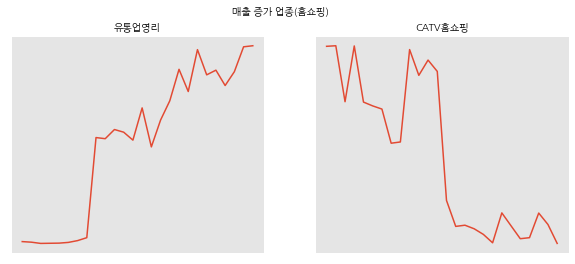

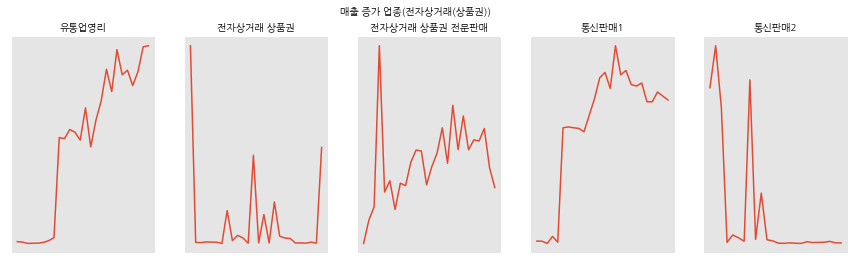

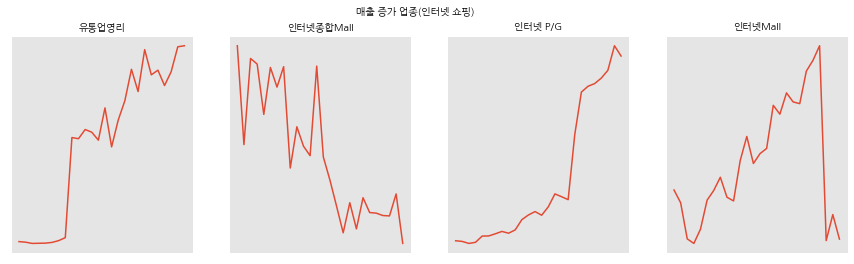

In [32]:
in1 = ['유통업영리']
in2 = ['CATV홈쇼핑']
showplot(in1,in2,subtitle='(홈쇼핑)')
in1 = ['유통업영리']
in2 = ['전자상거래 상품권','전자상거래 상품권 전문판매','통신판매1','통신판매2']
showplot2(in1,in2,subtitle='(전자상거래(상품권))')
in1 = ['유통업영리']
in2 = ['인터넷종합Mall','인터넷 P/G','인터넷Mall']
showplot2(in1,in2,subtitle='(인터넷 쇼핑)')

3. 교통
  1. 자동차
  2. 연료

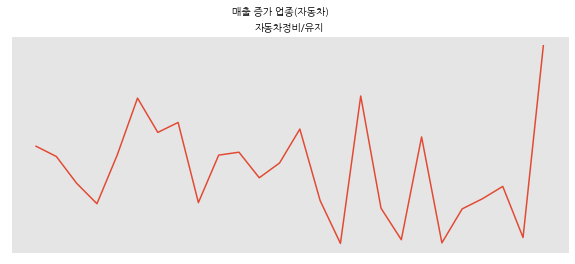

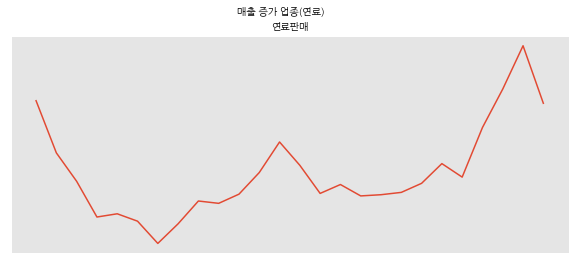

In [19]:
in1 = ['자동차정비/유지']
showplot(in1,subtitle='(자동차)')
in1 = ['연료판매']
showplot(in1,subtitle='(연료)')

## 소비 감소 업종
1. 관광 및 레저

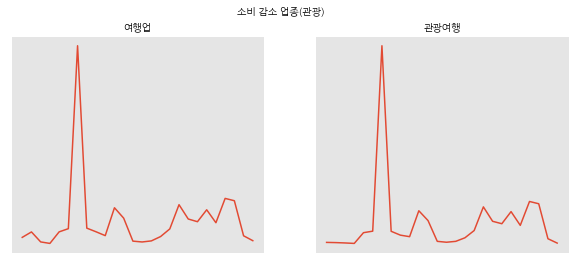

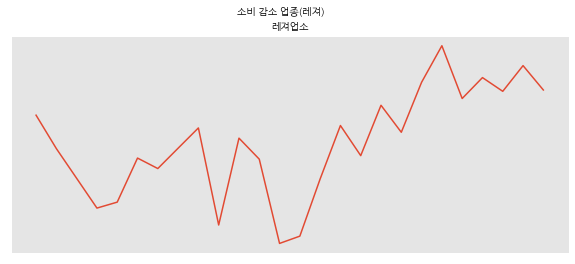

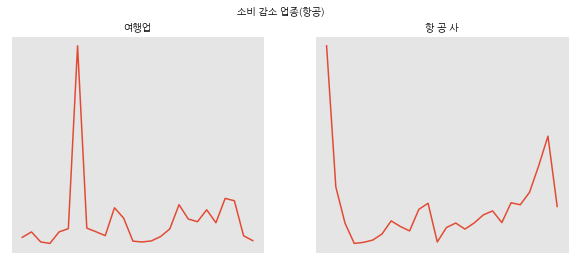

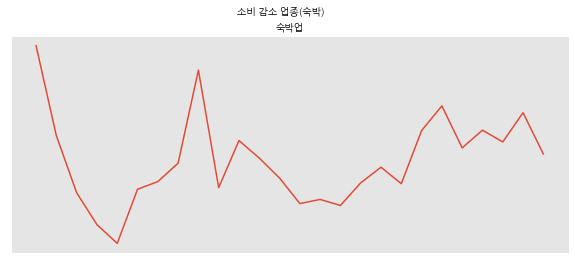

In [20]:
de1 = ['여행업']
de2 = ['관광여행']
showplot(de1,de2,title='소비 감소 업종',subtitle='(관광)')
de1 = ['레져업소']
showplot(de1,title='소비 감소 업종',subtitle='(레져)')
de1 = ['여행업']
de2 = ['항 공 사']
showplot(de1,de2,title='소비 감소 업종',subtitle='(항공)')
de1 = ['숙박업']
showplot(de1,title='소비 감소 업종',subtitle='(숙박)')

2. 유흥
  1. 유흥주점
  2. 단란주점

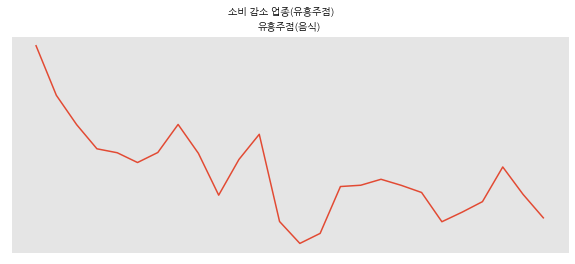

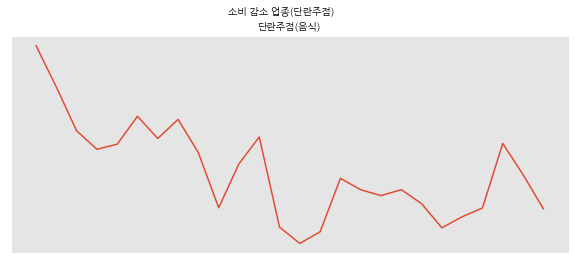

In [21]:
de1 = ['유흥주점(음식)']
showplot(de1,title='소비 감소 업종',subtitle='(유흥주점)')
de1 = ['단란주점(음식)']
showplot(de1,title='소비 감소 업종',subtitle='(단란주점)')

3. 쇼핑(오프라인)
  1. 대형할인점
  2. 면세점

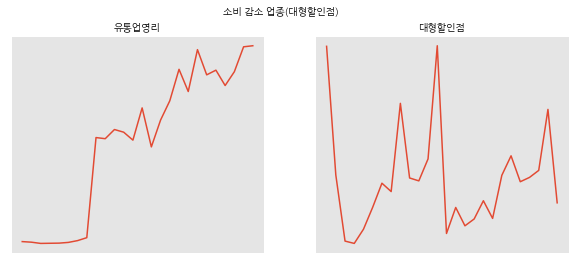

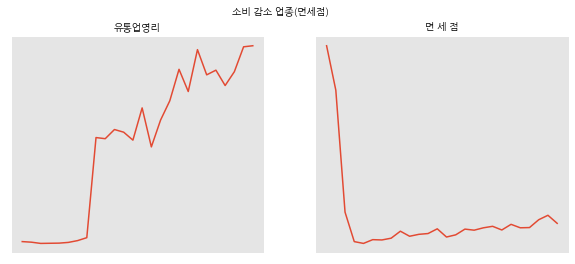

In [22]:
de1 = ['유통업영리']
de2 = ['대형할인점']
showplot(de1,de2,title='소비 감소 업종',subtitle='(대형할인점)')
de1 = ['유통업영리']
de2 = ['면 세 점']
showplot(de1,de2,title='소비 감소 업종',subtitle='(면세점)')

* 민간 소비의 침체
  * 민간 수요가 GDP에서 차지하는 비중은 코로나 위기 이전 78.2% 에서 위기 이후 77%로 하락했습니다.
  * 업종별로 차이가 있는 소비 침체의 영향입니다.

### 산업 구조 분석

* 산업별 고용률 변화 (통계청, ~ 21.12)
  * 20년 2월 고용률을 100%로 가정하고 고용률 변화를 백분율로 표현
  * 고용률 160% 이상인 데이터는 이상치로 판단해 제거

In [33]:
recruitpath = '/content/drive/MyDrive/datacon_data/data/recruitment/recruit.csv'
recruit = pd.read_csv(recruitpath,encoding='euc-kr')
recruit.columns = recruit.columns.str.replace('. ', '')
recruit.set_index('date',inplace = True)
recruit = recruit.transpose()
recruit.head(5)

date,전체,B.광업(05~08),C.제조업(10~34),"D.전기, 가스, 증기 및 공기 조절 공급업(35)","E.수도, 하수 및 폐기물 처리, 원료 재생업(36~39)",F.건설업(41~42),G.도매 및 소매업(45~47),H.운수 및 창고업(49~52),I.숙박 및 음식점업(55~56),J.정보통신업(58~63),K.금융 및 보험업(64~66),L.부동산업(68),"M.전문, 과학 및 기술 서비스업(70~73)","N.사업시설 관리, 사업 지원 및 임대 서비스업(74~76)","O.공공행정, 국방 및 사회보장 행정(84)",P.교육 서비스업(85),Q.보건업 및 사회복지 서비스업(86~87),"R.예술, 스포츠 및 여가관련 서비스업(90~91)","S.협회 및 단체, 수리 및 기타 개인 서비스업(94~96)"
201901,847824,570,129893,1143,4224,166211,76475,24262,104362,17625,9831,15678,34421,93170,28591,29269,69831,17605,24662
201902,700088,655,106951,513,3091,150887,80632,15696,103238,12222,5689,9400,24476,55105,15911,22328,62589,13001,17703
201903,1078657,881,121102,720,4041,246954,89722,22950,119082,14221,6321,11159,28718,68422,27832,170283,105608,18789,21852
201904,880406,838,129647,877,4357,254623,83617,18940,112907,15823,7383,11506,27341,75926,13453,25964,62895,15827,18482
201905,836176,749,113919,768,3897,274537,68553,20409,110914,12140,5486,10810,23972,70825,11751,21114,53820,13189,19324


In [34]:
recruit.drop(['전체','I.숙박 및 음식점업(55~56)'],axis=1,inplace=True)
r_cols = list(recruit.columns)

In [35]:
recruit = recruit.loc['202002':'202112']

In [26]:
# list percent convert
def list_percentage(l):
  c = l[0]
  for i,a in enumerate(l):
    l[i] = (a/c)*100
    if l[i]>=160:
      return False
  return True

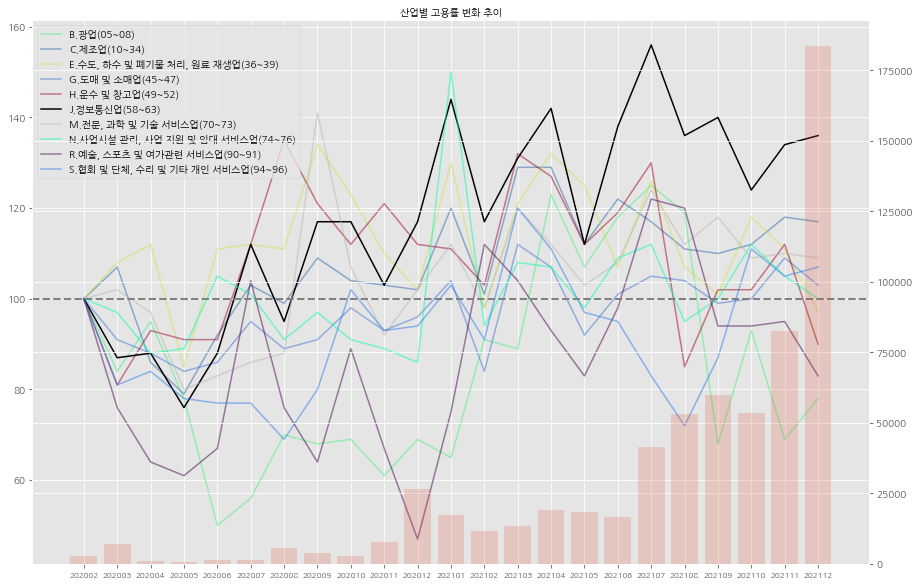

In [41]:
df = pd.read_csv(pathlist[0],encoding='euc-kr')
df = convert_monthly(df,start = '202002',end = '202112')
time = df.index.values.tolist()
palette = color_gen(len(recruit.columns))
plt.figure(figsize = (15,10))
for i,ty in enumerate(r_cols):
  sub = recruit[ty]
  flag = list_percentage(sub)
  # 고용률이 비정상적으로 높아지는 경우는 제외
  if not flag: continue
  alpha = 0.5
  if(ty=='J.정보통신업(58~63)'):
    palette[i] = '#000000'
    alpha = 1
  plt.style.use('ggplot')
  plt.plot(sub,label=ty,color=palette[i],alpha = alpha)
  plt.xticks(fontsize=8)
plt.legend(loc='best')
plt.axhline(100, 0, 1, color='gray', linestyle='--', linewidth=2)
plt.twinx()
plt.bar(x=time,height=df['계(명)'],alpha=0.2)
plt.title('산업별 고용률 변화 추이',fontsize = 30,fontproperties=font_name)
plt.show()

* 정보 통신업의 취업자수는 코로나 이전보다 상승했습니다.
* 전통적인 제조업 및 도소매업은 코로나 이전 수준을 회복하지 못하는 상황